##PyTorch Implementation for Mushroom Image Classification with ResNet50 model

In [ ]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
from torch import nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
import torchvision.models as models
from PIL import Image
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#image_folder = '/content/drive/My Drive/data/data/'

# Define your dataset directory (adjust this path to your Google Drive location)
data_dir = '/content/drive/My Drive/data/data'

Mounted at /content/drive


In [ ]:
# Count all valid images
class_folders = os.listdir(data_dir)

image_count = 0

for class_name in class_folders:
  class_path = os.path.join(data_dir, class_name)
  if os.path.isdir(class_path):
    for file in os.listdir(class_path):
      if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        image_count += 1
print(f"Total images found: {image_count}")



Total images found: 3122


In [ ]:
class MushroomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the mushroom class folders
            transform (callable, optional): Optional transform to be applied
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.samples = self._load_samples()

    def _load_samples(self):
        """Helper to load all valid image paths and their labels"""
        samples = []
        for class_name in self.classes:
            class_idx = self.class_to_idx[class_name]
            class_path = os.path.join(self.root_dir, class_name)

            # Skip if not a directory
            if not os.path.isdir(class_path):
                continue

            for file_name in os.listdir(class_path):
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    img_path = os.path.join(class_path, file_name)
                    samples.append((img_path, class_idx))

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        try:
            # Open image and convert to RGB (handles grayscale images)
            image = Image.open(img_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            return image, label

        except Exception as e:
            print(f"Error loading {img_path}: {str(e)}")
            # Return a placeholder if image is corrupted
            dummy_img = torch.zeros(3, 224, 224)  # Adjust size as needed
            return dummy_img, label


In [ ]:

# Define your transforms
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
# Initialize dataset
custom_dataset = MushroomDataset(root_dir=data_dir, transform=data_transforms)


print(f"Total classes: {len(custom_dataset.classes)}")
print(f"Total images: {len(custom_dataset)}")


# Split into train/val/test (80%/10%/10%)
train_size = int(0.8 * len(custom_dataset))
val_size = int(0.1 * len(custom_dataset))
test_size = len(custom_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    custom_dataset, [train_size, val_size, test_size]
)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")



Total classes: 215
Total images: 3122
Train: 2497, Val: 312, Test: 313


torch.Size([3, 224, 224])


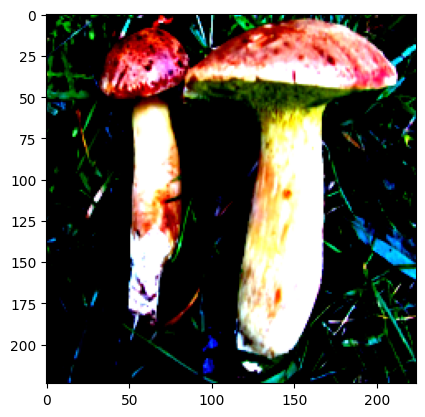

In [ ]:
index = np.random.randint(1,len(train_dataset))

img = train_dataset.__getitem__(index)[0]
print(img.shape)

plt.imshow(img.permute(1,2,0))

In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print("Number of Train batches: ", len(train_loader))
print("Number of val   batches: ", len(val_loader))
print("Number of Test  batches: ", len(test_loader))

# Verify a batch
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")  # Should be [32, 3, 224, 224]
    break

Number of Train batches:  79
Number of val   batches:  10
Number of Test  batches:  10
Batch shape: torch.Size([32, 3, 224, 224])


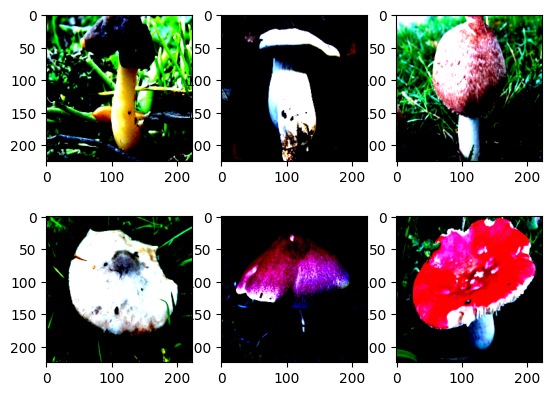

In [ ]:
for i in range(6):
     plt.subplot(2,3,i+1)
     plt.imshow(images[i].permute(1,2,0))

plt.show()

#Model: ResNet50

In [ ]:
# Define the Convolutional Neural Network

# Initialize ResNet (using ResNet18 as example)
model = models.resnet50(pretrained=True)  # Load pretrained weights

# Modify final layer for my 215 mushroom classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(custom_dataset.classes))  # 215 classes




/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]


In [ ]:
input_size = (3, 224, 224)
n_class = len(custom_dataset.classes)

# Move model to device
model = model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from torchsummary import summary
summary(model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# Loss function (better for classification than MSE)
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
# Hyperparameters
num_epochs = 10
best_val_acc = 0.0

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    n_correct_train = 0
    n_samples_train = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate metrics
        _, predicted = torch.max(outputs.data, 1)
        n_samples_train += labels.size(0)
        n_correct_train += (predicted == labels).sum().item()
        running_loss += loss.item()

        # Print batch progress
        if (batch_idx+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}')

    # Training metrics
    train_acc = 100.0 * n_correct_train / n_samples_train
    train_loss = running_loss / len(train_loader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)


    # Validation phase
    model.eval()
    val_loss = 0.0
    n_correct_val = 0
    n_samples_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            n_samples_val += labels.size(0)
            n_correct_val += (predicted == labels).sum().item()
            val_loss += loss.item()

    # Validation metrics
    val_acc = 100.0 * n_correct_val / n_samples_val
    val_loss = val_loss / len(val_loader)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)


    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_mushroom_model.pth')
        print(f'New best model saved with val_acc: {val_acc:.2f}%')

    # Epoch summary
    print(f'\nEpoch [{epoch+1}/{num_epochs}] => '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')


New best model saved with val_acc: 0.64%

Epoch [1/10] => Train Loss: 5.5456, Train Acc: 0.24% | Val Loss: 11.8053, Val Acc: 0.64%

Epoch [2/10] => Train Loss: 5.3614, Train Acc: 0.60% | Val Loss: 5.3796, Val Acc: 0.32%

Epoch [3/10] => Train Loss: 5.3202, Train Acc: 0.92% | Val Loss: 7.5556, Val Acc: 0.32%
New best model saved with val_acc: 1.28%

Epoch [4/10] => Train Loss: 5.1609, Train Acc: 1.36% | Val Loss: 5.1659, Val Acc: 1.28%
New best model saved with val_acc: 1.60%

Epoch [5/10] => Train Loss: 5.0527, Train Acc: 1.44% | Val Loss: 5.7398, Val Acc: 1.60%
New best model saved with val_acc: 2.56%

Epoch [6/10] => Train Loss: 4.8561, Train Acc: 2.56% | Val Loss: 4.7874, Val Acc: 2.56%
New best model saved with val_acc: 3.21%

Epoch [7/10] => Train Loss: 4.6078, Train Acc: 4.33% | Val Loss: 5.0089, Val Acc: 3.21%
New best model saved with val_acc: 3.85%

Epoch [8/10] => Train Loss: 4.3661, Train Acc: 6.17% | Val Loss: 6.1362, Val Acc: 3.85%
New best model saved with val_acc: 5.77%


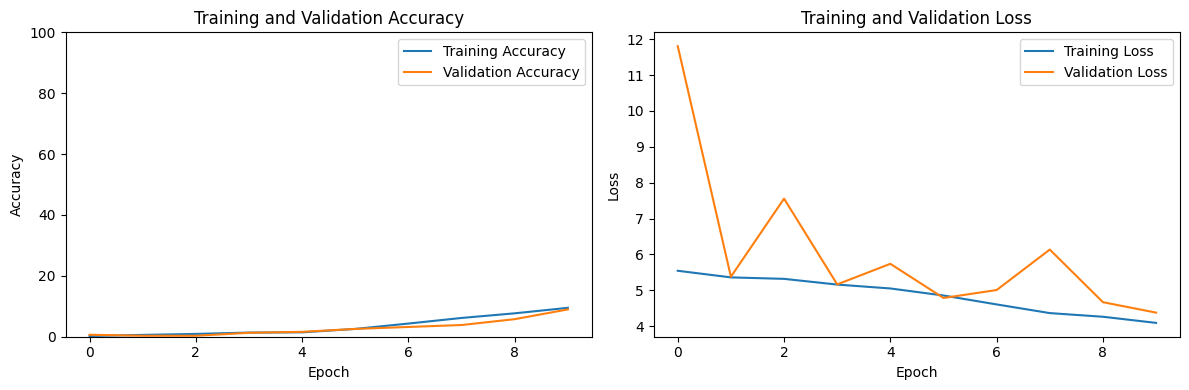

In [ ]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 100])  # 0-100% range
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
# 1. Load your best saved model
model.load_state_dict(torch.load('best_mushroom_model.pth'))
model.eval()  # Set to evaluation mode


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# 2. Initialize metrics
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []

# 3. Disable gradient calculation for testing
with torch.no_grad():
    for images, labels in test_loader:
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Calculate metrics
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss += loss.item()

        # Store for confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 4. Calculate final metrics
test_loss = test_loss / len(test_loader)
test_acc = 100 * correct / total

print(f'\nTest Results:')
print(f'Loss: {test_loss:.4f} | Accuracy: {test_acc:.2f}%')
print(f'Correct: {correct}/{total}')



Test Results:
Loss: 4.4078 | Accuracy: 9.58%
Correct: 30/313
